## **Task 1 State Vector simulation of quantum circuits**

#### 1) Naive simulation using matrix multiplication

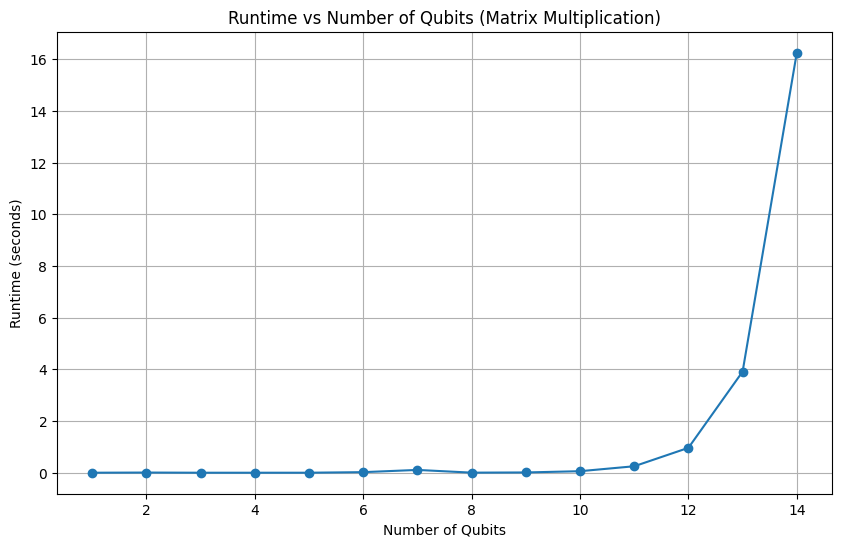

In [21]:
import numpy as np
import time
import matplotlib.pyplot as plt

I = np.array([[1, 0],
              [0, 1]], dtype=complex)

X = np.array([[0, 1],
              [1, 0]], dtype=complex)

H = (1 / np.sqrt(2)) * np.array([[1, 1],
                                 [1, -1]], dtype=complex)

CNOT = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1],
                 [0, 0, 1, 0]], dtype=complex)

def single_qubit_gate(n, gate, target):
    gates = [I] * n
    gates[target] = gate
    full_gate = gates[0]
    
    for g in gates[1:]:
        full_gate = np.kron(full_gate, g)
    return full_gate

def two_qubit_gate(n, gate, control, target):
    P0 = np.array([[1, 0], [0, 0]], dtype=complex)
    P1 = np.array([[0, 0], [0, 1]], dtype=complex)
    gates = [I] * n

    gates[control] = P0
    term1 = gates[0]
    for g in gates[1:]:
        term1 = np.kron(term1, g)

    gates[control] = P1
    gates[target] = gate
    term2 = gates[0]
    for g in gates[1:]:
        term2 = np.kron(term2, g)

    return term1 + term2

num_qubits_list = []
runtime_list = []

max_qubits = 14
for n in range(1, max_qubits + 1): 
    num_qubits_list.append(n)
    state_vector = np.zeros(2**n, dtype=complex)
    state_vector[0] = 1

    start_time = time.time()

    H_state = single_qubit_gate(n, H, 0)
    state_vector = np.dot(H_state, state_vector)

    if n >= 2:
        CNOT_state = two_qubit_gate(n, X, 0, 1)
        state_vector = np.dot(CNOT_state, state_vector)

    X_state = single_qubit_gate(n, X, n - 1)
    state_vector = np.dot(X_state, state_vector)

    end_time = time.time()
    runtime = end_time - start_time
    runtime_list.append(runtime)

plt.figure(figsize=(10, 6))
plt.plot(num_qubits_list, runtime_list, marker='o')
plt.title('Runtime vs Number of Qubits (Matrix Multiplication)')
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (seconds)')
plt.grid(True)
plt.show()


#### 2) Advanced simulation using tensor multiplication

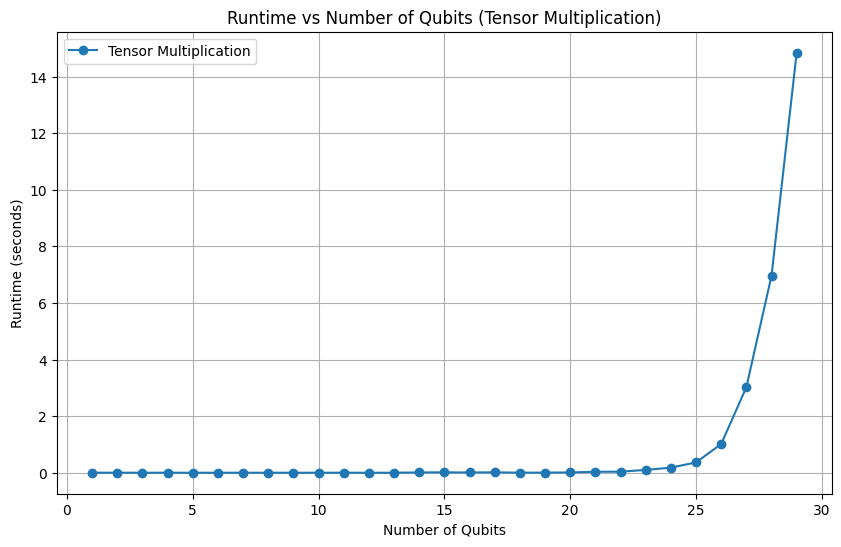

In [22]:
import numpy as np
import time
import matplotlib.pyplot as plt

I = np.array([[1, 0],
              [0, 1]], dtype=complex)

X = np.array([[0, 1],
              [1, 0]], dtype=complex)

H = (1 / np.sqrt(2)) * np.array([[1, 1],
                                 [1, -1]], dtype=complex)

CNOT = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1],
                 [0, 0, 1, 0]], dtype=complex)

def apply_single_qubit_gate(psi, gate, target):
    psi = np.moveaxis(psi, target, 0)
    psi = np.tensordot(gate, psi, axes=([1], [0]))
    psi = np.moveaxis(psi, 0, target)
    
    return psi

def apply_two_qubit_gate(psi, gate, control, target):
    if control > target:
        control, target = target, control

    psi = np.moveaxis(psi, [control, target], [0, 1])

    rest_shape = psi.shape[2:]
    psi = psi.reshape(4, -1)
    gate = gate.reshape(4, 4)
    psi = np.dot(gate, psi)

    psi = psi.reshape(2, 2, *rest_shape)
    psi = np.moveaxis(psi, [0, 1], [control, target])
    
    return psi

num_qubits_list = []
runtime_list = []

max_qubits = 29
for n in range(1, max_qubits + 1):
    num_qubits_list.append(n)
    
    psi_shape = [2] * n
    psi = np.zeros(psi_shape, dtype=complex)
    psi[(0,) * n] = 1 

    start_time = time.time()

    psi = apply_single_qubit_gate(psi, H, 0)

    if n >= 2:
        psi = apply_two_qubit_gate(psi, CNOT, 0, 1)

    psi = apply_single_qubit_gate(psi, X, n - 1)

    end_time = time.time()
    runtime = end_time - start_time
    runtime_list.append(runtime)
    
plt.figure(figsize=(10, 6))
plt.plot(num_qubits_list, runtime_list, marker='o', label='Tensor Multiplication')
plt.title('Runtime vs Number of Qubits (Tensor Multiplication)')
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (seconds)')
plt.grid(True)
plt.legend()
plt.show()


#### 3) Bonus question
##### a. Sampling from the final states in the tensor representation

In [23]:
import numpy as np
from collections import Counter

n = 2  
psi_shape = [2] * n
psi = np.zeros(psi_shape, dtype=complex)
psi[(0,) * n] = 1.0  

H = (1 / np.sqrt(2)) * np.array([[1, 1],
                                 [1, -1]], dtype=complex)
CNOT = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1],
                 [0, 0, 1, 0]], dtype=complex)

psi = apply_single_qubit_gate(psi, H, 0)
psi = apply_two_qubit_gate(psi, CNOT, 0, 1)

state_vector = psi.flatten()
probabilities = np.abs(state_vector) ** 2
probabilities /= np.sum(probabilities)

num_samples = 1000
states = np.arange(2 ** n)
samples = np.random.choice(states, size=num_samples, p=probabilities)

bitstrings = [format(state, f'0{n}b') for state in samples]
counts = Counter(bitstrings)

print("Measurement results:")
for bitstring, count in counts.items():
    print(f"{bitstring}: {count}")


Measurement results:
00: 498
11: 502


##### b) Computing exact expectation values in the form <Ψ| Op |Ψ>

In [24]:
import numpy as np

X = np.array([[0, 1],
              [1, 0]], dtype=complex)
I = np.array([[1, 0],
              [0, 1]], dtype=complex)
H = (1 / np.sqrt(2)) * np.array([[1, 1],
                                 [1, -1]], dtype=complex)

def compute_expectation_value(psi, Op, qubits):
    """Computes the expectation value of operator Op acting on the specified qubits using tensor products."""
    n = psi.ndim
    operators = [I] * n
    
    for q in qubits:
        operators[q] = Op

    full_operator = operators[0]
    for op in operators[1:]:
        full_operator = np.kron(full_operator, op)

    psi_flat = psi.flatten()
    expectation = np.vdot(psi_flat, np.dot(full_operator, psi_flat))
    
    return expectation.real

n = 1
psi_shape = [2] * n
psi = np.zeros(psi_shape, dtype=complex)
psi[(0,) * n] = 1

psi = apply_single_qubit_gate(psi, H, 0)

expectation_value = compute_expectation_value(psi, X, [0])
print(f"Expectation value of X on qubit 0: {expectation_value}")


Expectation value of X on qubit 0: 0.9999999999999998
